# Introduction

This is the third part of a python based system to analyse news headlines published around the world for signs of epidemics based on the kind of monitoring the World Health Organisation (WHO) conducts. Several steps are involved:

* The first phase of this program parsed news headlines. 
* The second part associated locations to the headlines. 
* The third part (this notebook) involving KMeans and DBSCAN clustering. 

Clustering headlines based on the geographic coordinates using both k-means clustering and DBSCAN. Visualising the clusters on a world map to check the results and optimse the parameters. 

# Obtaining Geonames Data

The geonames dataset is used to provide a respository of location names from around the world.   There are several ways to access geonames data:

* install the geonamescahce locally
* use the geonames webservices REST API or 
* download the geonames data and instantiate a local database.

To access Geonames data in local memory (ie a geonames cache) install the geonamescahce library. If using anaconda the conda import for this data is not compatable with python 3 and so the following pip install needs to be used to install the library: *pip install geonamescache* (similar comments apply to the unidecode library).

To access the online webservices API use the unencrypted URI http://api.geonames.org/search which is provided below in the *geonamesapi* variable in the parameters cell. Accessing the online service is easy and efficient. There are two versions: a free version and a paid for version. The free version limits the number of requests to 1000 per hour. If you exceed this limit your requests are throttled. The paid for service does not have this constraint, but then its a paid for service!

To access through a local database (in my case a MySQL database) use the instructions given in http://codigofuerte.github.io/GeoNames-MySQL-DataImport/downloading_data.html

The process is quite straight forward:
* download the files from the above github repro above (geonames_importer.sh, admin1CodesASCII.txt, allCountries.txt etc)
* download the data using the script (geonames_importer.sh)
* startup your MySQL server (I uses the Bitnami WAMP deployment and MySQL Workbench)
* create thedatabase using the script (geonames_importer.sh)
* import the data using the script (geonames_importer.sh)

The download script will unzip the original files downloaded from geonames in a folder called "data". This folder will contain all the data needed for the "import-dump" action which populates the database.



In [14]:
import re
import pandas as pd
import logging
import geonamescache
import unidecode
import requests
import json
from enum import Enum
import mysql.connector
from mysql.connector import Error

#I found this necessary to get around a problem with the environment
#There are probably other (better?) ways of doing this...
import os
prefix = os.environ["CONDA_PREFIX"]
lib = prefix + "\Library\share"
os.environ["PROJ_LIB"]=lib
print(f'PROJ_LIB environment variable set to {os.environ["PROJ_LIB"]}')
from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN
import numpy as np

from math import cos, sin, asin, radians, sqrt


PROJ_LIB environment variable set to D:\Anaconda3\envs\discovering-disease-outbreaks\Library\share


# Parameters

Global parameters


In [15]:
log_file = 'headlines.log'                       # Log file location and name
headlines_file = "../data/headlines0.txt"         # Test headlines files location
log_level = logging.INFO                         # Log level to generate log out for
sequence_length = 5                              # Sequence of words to check as location name
geonamesapi = 'http://api.geonames.org/search'   # geonames API URI
geonamescountryapi = 'http://api.geonames.org/countryInfo'   # geonames countrycodes API URI
class LocationData(Enum):                        # Options for location data: 
    WEB_SERVICES = 1                             # - Use geonames web service
    LOCAL_DB = 2                                 # - Use local db with geonames data
    CACHE = 3                                    # - Use geonamescache
    REGEXP = 4                                   # - Use regexp
location_data = LocationData.CACHE         # Selected source of location data

#################################################################################
# Create a personal user name on geonames to use the web api                    #
username = 'kwatkins973'                        
#################################################################################

dbhost="localhost"                               # Host for database
dbport=3306                                      # port number
dbname="geonames"                                # database name
dbusername="root"                                # atabase user id
dbpassword="abidex123"                           # password for user

###############################################################################
# For KMeans clustering gives the number of clusters and the colours to codes
# the locations
#################################################################################
colour_array = ['g', 'k', 'r', 'b', 'w', 'v']
num_kmeans_clusters = 6

epsilon = 50
min_points =  5



# Setup

Various setup values to allow either a local (via local database) or remote (via web service APIS calls|) geonames version of the news parser implementation.


In [16]:

###################################################################
# Terms used to identify relevant news headlines                  #
###################################################################
illnesses = ['Zika', 'Flu', 'Mad Cow', 'Meningitis', 'Cholera', 'Measles', 
             'Gonorrhea', 'Rabies', 'Malaria', 'Respiratory Syncytial', 'Bronchitis',
             'Hepatitis', 'Dengue', 'Influenza', 'Ebola', 'Tuberculosis', 'Norovirus',
             'HIV', 'Cholera', 'Pneumonia', 'Rhinovirus', 'Rotavirus', 'Mumps', 'Gonorrhea',
             'Syphilis', 'Chikungunya', 'Chickenpox', 'Chlamydia', 'Varicella', 'Varicella',
             'Herpes', 'Cancer', 'Caronavirus', 'Covid-19']
indicators = ['pandemic', 'virus', 'disease', 'eipdemic', 'vaccine']

###################################################################
# The target dataframe                                            #
###################################################################
illness_data = pd.DataFrame(columns = ['Headline', 'Diseases', 'Country', 'Country Code', 'City', 'Latitude', 'Longitude'])

###################################################################
# Logging configuration                                           #
###################################################################
logging.basicConfig(filename=log_file,
                    filemode='a',
                    level=log_level,
                    format='%(asctime)s %(levelname)s [%(filename)s:%(lineno)d] - %(message)s',
                    datefmt='%m-%d %H:%M')

###################################################################
# Geonames data to resolve location names                         #
# (cities/districts/counrties)                                    #
###################################################################
gc = geonamescache.GeonamesCache()
cities = [city for city in gc.get_cities().values() if city['name'] == 'Miami']
countries = [country for country in gc.get_countries().values() if country['name'] == 'United States'] 
print(cities) 
print(countries) 

###################################################################
# Define punctation                                               #
# '-' , ''' explicitly removed as its in some location names      #
###################################################################
punctuation = r'!"#$%&\()*+,./:;<=>?@[\\]^_`{|}~'  
exclude = set(punctuation)

def geonames_info():
    if location_data == LocationData.WEB_SERVICES:
        return 'Getting geonames data from remote web services calls'
    elif location_data == LocationData.LOCAL_DB:
        return 'Getting geonames data from local MySQL database'
    elif location_data == LocationData.CACHE:
        return 'Getting geonames data from geonames cache'
    else:
        return 'Getting geonames data using regular expression'

###################################################################
# Create  regular expressions for identfying relevant news items  #
###################################################################
def arrayToExp(values):
    """
    Convert an array of terms into a regular expression where each letter group is 
    separated with a choice operator.
    """
    exp =  ""
    exp = values[0]+exp.join(['|'+elem for elem in values[1:]])
    return exp

illness_exp = arrayToExp(illnesses)
print(illness_exp)
indicators_exp = arrayToExp(indicators)
print(indicators_exp)

illness_regexp = re.compile(illness_exp, re.IGNORECASE)
indicators_regexp = re.compile(indicators_exp, re.IGNORECASE)

# Get location data
locations_regexp = re.compile('in\s+(((st(\.)?|key|saint|north|south|east|west|'
                              'san|palm|la|new|sao|santa|los|las|rio( de)?|'
                              'santos|fort|hong|bella|oak|new)\s+)?(\w+))', re.IGNORECASE)
locations1_regexp = re.compile('in\s+((\s+[a-zA-Z\-]+)+)', re.IGNORECASE)
locations2_regexp = re.compile('in\s+((\s+[a-zA-Z\-]+)+)', re.IGNORECASE)

###################################################################
# Open and Close connections to the local MySQL database          #
###################################################################
coonnection = ''
cursor = ''
def close_db_connection():
    global connection
    global cursor
    if (connection.is_connected()):
        logging.info("Closing connection to local MySQL")
        cursor.close()
        connection.close()
        print("MySQL connection closed")

def open_db_connection():
    global connection
    global cursor
    try:
        connection = mysql.connector.connect(host     = dbhost,
                                             database = dbname,
                                             user     = dbusername,
                                             port     = dbport,
                                             password = dbpassword)
        if connection.is_connected():
            logging.info("Opening connection to local MySQL")
            db_Info = connection.get_server_info()
            print("Connected to MySQL Server version ", db_Info)
            cursor = connection.cursor()
            cursor.execute("select database();")
            record = cursor.fetchone()
            cursor.close()
            
        return
        
    except Error as e:
        print("Error while connecting to MySQL", e)
        logging.error("Cannot connect to local MySQL: " + e)
        if (connection.is_connected()):
            close_db_connection()
            logging.error("Finally: MySQL connection closed")


[{'geonameid': 4164138, 'name': 'Miami', 'latitude': 25.77427, 'longitude': -80.19366, 'countrycode': 'US', 'population': 441003, 'timezone': 'America/New_York', 'admin1code': 'FL'}]
[{'geonameid': 6252001, 'name': 'United States', 'iso': 'US', 'iso3': 'USA', 'isonumeric': 840, 'fips': 'US', 'continentcode': 'NA', 'capital': 'Washington', 'areakm2': 9629091, 'population': 310232863, 'tld': '.us', 'currencycode': 'USD', 'currencyname': 'Dollar', 'phone': '1', 'postalcoderegex': '^\\d{5}(-\\d{4})?$', 'languages': 'en-US,es-US,haw,fr', 'neighbours': 'CA,MX,CU'}]
Zika|Flu|Mad Cow|Meningitis|Cholera|Measles|Gonorrhea|Rabies|Malaria|Respiratory Syncytial|Bronchitis|Hepatitis|Dengue|Influenza|Ebola|Tuberculosis|Norovirus|HIV|Cholera|Pneumonia|Rhinovirus|Rotavirus|Mumps|Gonorrhea|Syphilis|Chikungunya|Chickenpox|Chlamydia|Varicella|Varicella|Herpes|Cancer|Caronavirus|Covid-19
pandemic|virus|disease|eipdemic|vaccine


# Parse Headlines

Loop through the headlines file and extract those headlines that look like they relate to news items about deseases.


In [20]:
def query_cache(name: str, country_hint):
    '''
    Returns a location that has been matched in the geonamescache along with the associated
    countries. 
    A 'countryHint' parameter provides help in resolving ambiguities where there are more than one 
    location in the geonames database matching the parameter 'name'. If several names in geonames 
    match the name parameter then all countries containing those locations are captured. 

    Parameters
    ----------
    name : string
        The name or a sequence of names being matched to the geonames repositorry.
    country_hint : string
        Used as the name of the country in order to resolve ambiguities and 
        asumed to be determined from  context.

    Returns
    -------
    string
        The name of the City when a match is made or 'Unknown' in the absence 
        of a match or 'Invalid' when an error has been found.
    string
        A list of corresponding countreis or 'Unknown' in the absence 
        of a match.
    latitude
        Latitude of the city
    longitude
        Longitude of the city
    '''
    # Remove apostrophes as they confuse the SQL query
    if name.find("'") != -1:
        place = name.split("'")[0]
    else:
        place = name

    city = [city['name'] for city in gc.get_cities().values() 
              if city['name'] == place]
    countrycodes = [city['countrycode'] for city in gc.get_cities().values() 
              if city['name'] == place]
    
    if city != ():
        countries = [country['name'] for country in gc.get_countries().values() 
                     if country['iso'] in countrycodes ] 
        return place, countries
    return 'Unknown', ['Unknown']


def location_from_cache (city_name, country_name):
    longitude = 0
    latitude = 0
    cc = "Unknown"
 
    country_codes = [country['iso'] for country in gc.get_countries().values() 
                     if country['name'] == country_name]
    
    locations = [(city['latitude'], city['longitude'], city['countrycode']) 
                 for city in gc.get_cities().values() 
                 if city['name'] == city_name and city['countrycode'] in country_codes]
    
    (latitude, longitude, cc) = locations[0]
    return latitude, longitude, cc

    
def query_db(name: str, country_hint):
    '''
    Returns a location that has been matched in a local database with
    geonames data along with the associated countries. 
    A 'countryHint' parameter provides help in resolving ambiguities where there are more than one 
    location in the geonames database matching the parameter 'name'. If several names in geonames 
    match the name parameter then all countries containing those locations are captured. 

    Parameters
    ----------
    name : string
        The name or a sequence of names being matched to the geonames repositorry.
    country_hint : string
        Used as the name of the country in order to resolve ambiguities and 
        asumed to be determined from  context.

    Returns
    -------
    string
        The name of the City when a match is made or 'Unknown' in the absence 
        of a match or 'Invalid' when an error has been found.
    string
        A list of corresponding countreis or 'Unknown' in the absence 
        of a match.  
    '''
    global connection
    # Remove apostrophes as they confuse the SQL query
    if name.find("'") != -1:
        place = name.split("'")[0]
    else:
        place = name
    sql_select_query = "select g.name, g.latitude, g.longitude, c.name " 
    sql_select_query += "from geoname g inner join countryinfo c "
    sql_select_query += "on c.iso_alpha2 = g.country where g.name = '" + place + "'"
    try:
        cursor = connection.cursor()
        cursor.execute(sql_select_query)
    except mysql.connector.Error as e:
        logging.error("SQL error: " + str(e))
        logging.error("When executing: " + sql_select_query)
        return 'Unknown', ['Unknown']
    
    records = cursor.fetchall()
    cursor.close()
    
    if len(records) > 0:
        countries = []
        for row in records:
            if row[3] not in countries:
                countries.append(row[3])
        return place, countries
    else:
        return 'Unknown', ['Unknown']
    
    
def location_from_db(city_name, country_name):
    global connection
    sql_select_query =  "select g.latitude, g.longitude, c.iso_alpha2 " 
    sql_select_query += "from geoname g inner join countryinfo c "
    sql_select_query += "on c.iso_alpha2 = g.country "
    sql_select_query += "where g.name = '" + city_name + "'" + " AND c.name = '" + country_name + "'" 
    try:
        cursor = connection.cursor()
        cursor.execute(sql_select_query)
    except mysql.connector.Error as e:
        logging.error("SQL error: " + str(e))
        logging.error("When executing: " + sql_select_query)
        cursor.close()
        return 90, 0, "Unknown"
    
    records = cursor.fetchall()
    cursor.close()
    
    if len(records) > 0:
        for row in records:
            return row[0], row[1], row[2]
    else:
        return 90, 0, "Unknown"


def location_from_web_services(city_name, country_name):
    params = { 'q': city_name,
               'maxrows': '100',
               'username': username,
               'type': 'json'
             }
    resp = requests.get(geonamesapi, params=params)
    if resp.status_code != 200:
        # This means something went wrong.
        logging.error("Access error (HTTP Status code: " + 
                      resp.status_code + 
                      ") searching for: " + city_name)
        return 90, 0, "Unknown"

    response = json.loads(resp.text) 

    # Extract city and country
    try:    
        for names in response['geonames']:
            if city_name == names['name'] and country_name == names['countryName']:
                latitude = names['lat']
                longitude = names['lng']
                cc = names['countryCode']
                return latitude, longitude, cc
        return 0,0, "Unknown"
    except KeyError:
        logging.error("KeyError detected searching for: " + city_name)
        return 90, 0, "Unknown"
    
    
def get_lat_long(city, country):
    if location_data == LocationData.CACHE:
        return location_from_cache(city, country)
    elif location_data == LocationData.WEB_SERVICES:
        return location_from_web_services(city, country)
    elif location_data == LocationData.LOCAL_DB:
        return location_from_db(city, country)
    else:
        return 90, 0, "Unknown"
    
    
def get_geonames(name, country_hint):
    '''
    Returns a geo name that has been matched by the geonames web service along with the associated
    country. 
    A 'countryHint' parameter provides help in resolving ambiguities where there are more than one 
    location in the geonames database matching the parameter 'name'. If several names in geonames 
    match the name parameter then all countries containing those locations are captured. 
    If one is the same as the countryHint  then this is assumed to be the correct country otherwise 
    the first country in the list is returned and countryHint is assumed to be wrong.
    if there are no matching names then ('unknown', 'unkown') is returned for name and country.
    If something whent wrong with the request then ('Invalid', 'Invalid') is returned.

    Parameters
    ----------
    name : string
        The name or a sequence of names being matched to the geonames repositorry.
    country_hint : string
        Used as the name of the country in order to resolve ambiguities and 
        asumed to be determined from the context.

    Returns
    -------
    string
        The name of the City when a match is made or 'Unknown' in the absence 
        of a match or 'Invalid' when an error has been found.
    string
        The name of the corresponding country r 'Unknown' in the absence 
        of a match or 'Invalid' when an error has been found.
    '''
    if name in illnesses:
        return 'Unknown', 'Unknown', 90, 0, "Unknown"
    
    response = ''
    place = ''    
    countries = []
    latitude = 0
    longitude = 0
    if location_data == LocationData.CACHE:
        place, countries = query_cache(name, country_hint)
    elif location_data == LocationData.WEB_SERVICES:
        # use the geonames web service
        params = { 'q': name,
                   'maxrows': '100',
                   'username': username,
                   'type': 'json'
                  }
        resp = requests.get(geonamesapi, params=params)
        if resp.status_code != 200:
            # This means something went wrong.
            logging.error("Access error (HTTP Status code: " + 
                          resp.status_code + 
                          ") searching for: " + name)
            return 'Invalid', 'Invalid', 90, 0, 'Unknown'
        
        response = json.loads(resp.text) 

        # Extract city and country
        try:    
            for names in response['geonames']:
                if (name == names['name']):
                    place = name
                    countries.append(names['countryName'])              
        except KeyError:
            logging.error("KeyError detected searching for: " + name)
            return 'Unknown', 'Unknown', 90, 0, 'Unknown'
    else:
        # use local database
        place, countries = query_db(name, country_hint) 

    if len(countries) > 0:
        if country_hint in countries:    
            latitude, longitude, country_code = get_lat_long(place, country_hint)
            return place, country_hint, latitude, longitude, country_code
        else:
            # Choose any
            latitude, longitude, country_code = get_lat_long(place, countries[0])
            return place, countries[0], latitude, longitude, country_code
    return 'Unknown', 'Unknown', 90, 0, "Unknown"


def purge_punctuation(s):
    '''
     Return the string passed in as a parameter with the punctuation removed

    Parameters
    ----------
    s : string
        The string to be remoeved.

    Returns
    -------
    string
        The input string with the punctation removed.
    '''
    return ''.join(ch for ch in s if ch not in exclude)
    

def check_using_geonames(words, country_hint, reverse = False):
    '''
    Check whether the sequence of words corresponds to a location using geonames.
    Choose the maximal sequence of words that corresepnds to a location.

    Parameters
    ----------
    words : List of strings
        The news headline as a list of strings.
    country_hint : string
        A country identifier when it can be obtained from the context to 
        resolve ambiguities.
    reverse : boolean, optional
        For processing word sequences from the end of the news headline. The default is False.

    Returns
    -------
    A place : string
        The name of a place (typically a city).
    A country : string
        The name of the country containing the city.

    '''
    place = ''
    previous_place = 'Unknown'
    previous_country = 'Unknown'
    previous_lat = 0
    previous_long = 0
    previous_country_code = "Unknown"

    
    found = False
    if reverse:
        res = words[::-1]
        words = res
    for i in range(len(words)):
        if reverse:
            place = words[i] + place
        else:
            place = place + words[i]
        found_place, found_country, latitude, longitude, country_code = get_geonames(place, country_hint)
        if found and (found_place == 'Unknown' or found_place == 'Invalid'):
            return previous_place, previous_country, previous_lat, previous_long, previous_country_code
        else:
            if found_place != 'Unknown' and found_place != 'Invalid' :
                found = True
            previous_place = found_place
            previous_country = found_country
            previous_lat = latitude
            previous_long = longitude
            previous_country_code = country_code
            if reverse:
                # Work backwards when at the end of a news headline
                place = ' ' + place
            else:
                place = place + ' '
    return previous_place, previous_country, previous_lat, previous_long, previous_country_code


def get_location_using_geonames(text: str, country_hint):
    '''
    Add the headline to the Headlines panda if it matches location data from the geonames
    web service.
    In the case that the headline does not match the illness regular expressions it is
    retained in a log file which leaves open the possiblity of fine-tuning the 
    search criteria to catch edge cases.

    Parameters
    ----------
    text : string
        A news headline.
    country_hint : string
        A country identifier when it can be obtained from the context to 
        resolve ambiguities. The default is 'Unknown'.

    Returns
    -------
    A place : string
        The name of a place (typically a city).
    A country : string
        The name of the country containing the city. It is expected that when reading 
        actual news sources that a country name can be assumed from the actual source
        of the news headline otherwise there is no way to disambiguate cities with
        the same name from differnet parts of the world.

    '''
    words = text.split() #split the sentence into individual words

    # If there is the word 'in' in the text then assume the words after refer to a location
    # take up to sequence_length of those words to match to a location in the geonames database
    if 'in' in words:
        pos = words.index('in')
        pos = pos + 1
        if len(words) > pos + sequence_length - 1:
            last_pos = pos + sequence_length
        else:
            last_pos = len(words)
        # check sequence of words from pos to max_pos against geonames
        place, country, latitude, longitude, country_code = check_using_geonames(words[pos:last_pos], country_hint)
        if place != 'Invalid' and place != 'Unknown':
            return place, country, latitude, longitude, country_code

    # Check whether the first few words correspond to a location
    pos = 0
    if len(words) > pos + sequence_length - 1:
        last_pos = pos + sequence_length
    else:
        last_pos = len(words)
    place, country, latitude, longitude, country_code = check_using_geonames(words[pos:last_pos], country_hint)
    if place != 'Invalid' and place != 'Unknown':
        return place, country, latitude, longitude, country_code
    
    # Check whether the last few names correspond to a location
    last_pos = len(words)
    if len(words) > sequence_length - 1:
        pos = last_pos - sequence_length
    else:
        pos = 0
    place, country, latitude, longitude, country_code = check_using_geonames(words[pos:last_pos], country_hint, 
                                          reverse = True)
    if place != 'Invalid' and place != 'Unknown':
        return place, country, latitude, longitude, country_code
    else:
        logging.warning("Location not found in geonames: " + text)
        return 'Unknown', 'Unknown', 90, 0, "Unknown"


def get_location(text: str, country_hint: str):
    '''
    USe a regular expression to identify candidate locations.
    
    Parameters
    ----------
    text : string
        A news headling.
    country_hint : string, optional
        A country identifier when it can be obtained from the context to 
        resolve ambiguities. The default is 'Unknown'.

    Returns
    -------
    A place : string
        The name of a place (typically a city).
    A country : string
        The name of the country containing the city.
    '''
    text = purge_punctuation(text)
    if location_data == LocationData.REGEXP:
        ################################################
        # For experimenting with regular expressions ...
        ################################################
        locations = locations_regexp.search(text)
        if locations:
            return locations.group(1), 'Unknown', 90, 0, "Unknown"
        else:
            return 'Unknown', 'Unknown', 90, 0, "Unknown"
    else:
        return get_location_using_geonames(text, country_hint)
    

def add_headline(text: str, country_hint = 'Unknown'):
    '''
    Add the headline to the Headlines panda if it matches the regular expression.
    The regualar expression is split into two kinds:
    - exact match based on an explict list of deseases and viruses
    - a separate match based on more generic indicators such as 'virus' on the assumption
      that increasing the probability of a true match will require more sophisticated
      linguistic analysis.
    In the case that the headline does not match the illness regular expressions it is
    retained in a log file which leaves open the possiblity of fine-tuning the 
    search criteria to catch edge cases.

    Parameters
    ----------
    text : str
        A news headline.
    country_hint : string, optional
        A country identifier when it can be obtained from the context to 
        resolve ambiguities. The default is 'Unknown'.

    Returns
    -------
    None.

    '''
    if text == "":
        logging.warning("Ignored blank line")
        return
    global illness_data
    utext = unidecode.unidecode(text)
 
    disease_list= illness_regexp.findall(utext)
    
    if disease_list :
        place, country, latitude, longitude, country_code = get_location(utext, country_hint)
        illness_data = illness_data.append({"Headline" : text,
                                            "Diseases" : disease_list,
                                            "Country" : country,
                                            "Country Code": country_code,
                                            "City" : place,
                                            "Latitude" : latitude,
                                            "Longitude" : longitude}, ignore_index=True)
    else:
        # Try indiators that might suggest the presence of a disease
        disease_list = indicators_regexp.findall(utext)
        
        # May need to make the analysis more sophisticated
        if disease_list:       
            place, country, latitude, longitude, country_code = get_location(utext, country_hint)
            illness_data = illness_data.append({"Headline" : text,
                                                "Diseases" : disease_list,
                                                "Country" : country,
                                                "Country Code": country_code,
                                                "City" : place,
                                                "Latitude": latitude,
                                                "Longitude" : longitude}, ignore_index=True)
        else:
            logging.warning("No disease reference: " + text)
        

def read_hedlines_file(filename = headlines_file):
    """
    Read a headlines file and check whether the headline relates to illnesses/deseases of interest.
    """
    print("Reading lines from " + filename)
    file = open(filename, 'r', encoding='utf-8')
    if location_data == LocationData.LOCAL_DB:
        open_db_connection()
    for line in file:
        add_headline(line.strip())
    if location_data == LocationData.LOCAL_DB:
        close_db_connection()
    file.close()

def get_coordinates(disease = "Influenza"):
    return ( illness_data[illness_data['Diseases'].apply((lambda x: disease in x) )] [['Latitude', 'Longitude']]  )

def great_circle_angle(lat1, lon1, lat2, lon2):
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return c

def great_circle_distance(lat1, long1, lat2, long2, unit = 'miles'):
    if unit == 'miles':
        return great_circle_angle(lat1, long1, lat2, long2) * 3956.0
    else:
        return great_circle_angle(lat1, long1, lat2, long2) * 6378.137




12428.14053760122
3.141592653589793


# Plot Locations of Reported Disease Outbreaks

This cell uses KMeans to cluster the outbreaks and indicate which cluster by colour coding the outbreak location.


Reading lines from ../data/headlines0.txt
[ 0  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  0  0  1  0  0  1  1
  0  1  1  1  1  1  1  1  1  1  1  0  1  1  1  0  0  0  1  1  0  1  1  0
  0  1  1  1  0  0  1  0  0  0  0  1  1  1  0  0  0  1  0  0  1  1  1  1
  1  1  1  1  1  0  0  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1
  1  1  1  0 -1  1  1  0  0  0  1  1  1  1  0  1  1  0  1  1  1  0  1  1
  1  0  1  1  0  0  1  1  0  1  1  1  1  1  1  1  1  0  0  0  1  1  1  1
  1  1  1  1  1  0  1  1  1  0  1  0  1  0  1  1  1  1  1  1  1  1  1  0
  1  1  1  1  0  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  0  1  1
  1  1  1  0  0  1  0  0  1  1  0  1  1  1  1  1  1  1  1  1  1  0  1  1
  1  0  0  0  1  1  0  1  1  0  0  1  1  1  0  0  1  0  0  0  0  1  1  1
  0  0  0  1  0  0  1  1  1  1  1  1  1  1  1  0  0  1  1  1  1  1  1  0
  1  1  1  1  1  1  1  1  1  1  1  1  1  0 -1  1  1  0  0  0  1  1  1  1
  0  1  1  0  1  1  1  0  1  1  1  0  1  1  0  0  1  1  0  1  1  1  1  1
  1  1  1

ValueError: not enough values to unpack (expected 2, got 0)

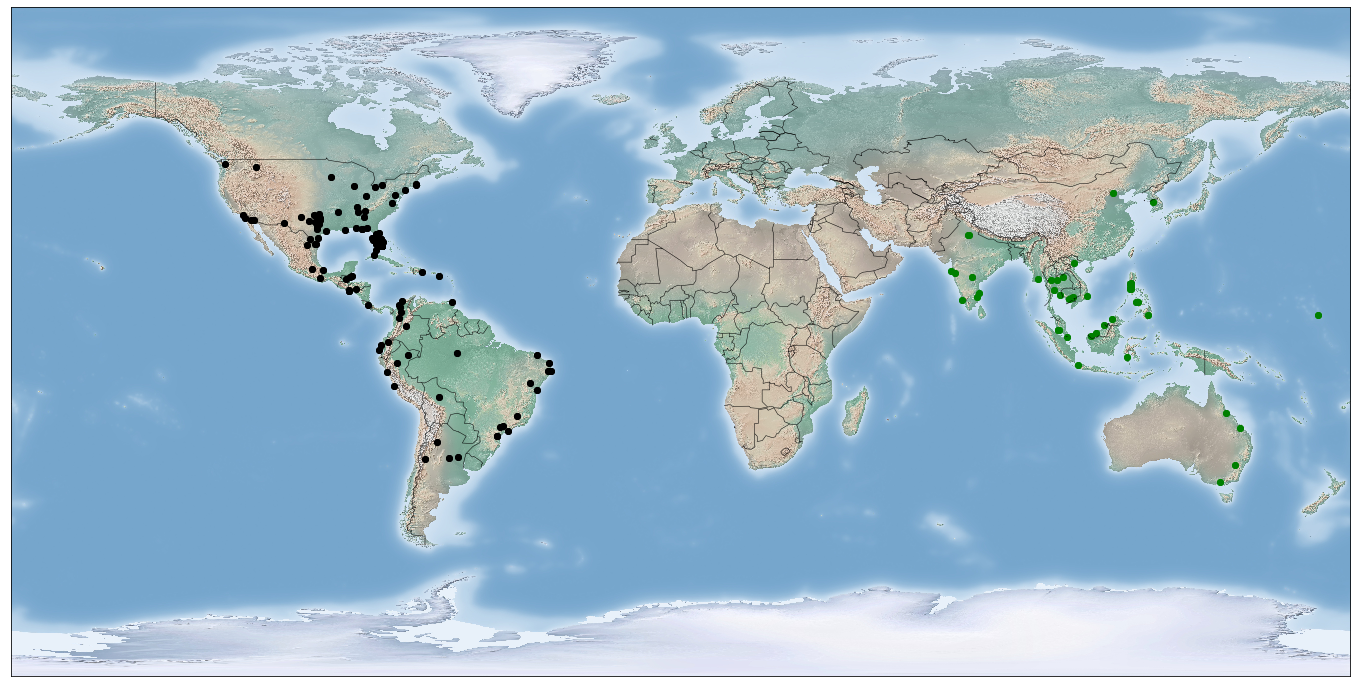

In [27]:
def create_map(locations, assigned_clusters):  
    fig = plt.figure(figsize=(24, 18))
    map_plotter = Basemap()
    map_plotter.drawcountries()
    map_plotter.shadedrelief()
    
    #map_plotter.scatter(locations[1], locations[0], latlon=True)
    
    for cls_index in range(num_kmeans_clusters):
        selected_locns = [locations[i] for i in range(len(locations))
                          if cls_index == assigned_clusters[i]]
        lats,longs = np.array(selected_locns).T
        map_plotter.scatter(longs, lats,
                    color=['g', 'k', 'r', 'b', 'w', 'c'][cls_index])
    
    plt.show()

def cluster_using_kmeans(coords):
    cluster_model = KMeans(n_clusters=num_kmeans_clusters)
    assigned_clusters = cluster_model.fit_predict(coords)
    return assigned_clusters

def cluster_using_dbscan(coords):
    global epsilon, min_points
    cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
    assigned_clusters = cluster_model.fit_predict(coords)
    return assigned_clusters

def main():
    read_hedlines_file()
    c = get_coordinates('Zika')
    c = c[c['Latitude'] != 90]
    # Choose between kmeans or dbscan
    #ac = cluster_using_kmeans(c)
    ac = cluster_using_dbscan(c)
    print(ac)
    create_map(c.values.tolist(), ac)

if __name__ == '__main__':
    main()



Reading lines from ../data/headlines0.txt


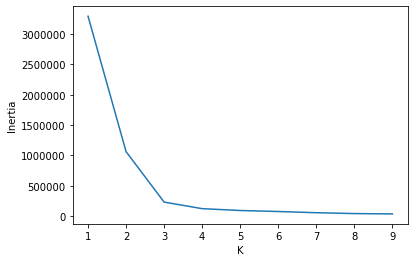

In [7]:
# Experiment with KMeans iniertia
##################################
read_hedlines_file()
c = get_coordinates('Zika')
    
k_values = range(1, 10)

#cluster_model = KMeans(n_clusters=num_kmeans_clusters)
#assigned_clusters = cluster_model.fit_predict(coords)

inertia_values = [KMeans(k).fit(c).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()



